In [1]:
%load_ext autoreload 
%autoreload 2

In [18]:
from glob import glob 
import pandas as pd 
from fastcore.xtras import load_pickle 

from gptchem.data import get_hea_phase_data
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from gptchem.evaluator import evaluate_classification
from gptchem.formatter import ClassificationFormatter
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH
import matplotlib.pyplot as plt 
import matplotlib as mpl


from scipy.stats import sem

import matplotx
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])
%matplotlib inline


## Get the dummy metrics

In [19]:
data = get_hea_phase_data()

In [20]:
estimators = ['uniform', 'stratified', 'most_frequent']
results = []
train_sizes = [10, 20, 50, 100, 200, 500]
for i in range(10): 
    for estimator in estimators:
        for train_size in train_sizes: 
            train, test = train_test_split(data, train_size=train_size, test_size=250, stratify=data['phase_encoded'], random_state=i) 
            classifier = DummyClassifier(strategy=estimator)
            classifier.fit(train['Alloy'], train['phase_encoded'])
            predictions = classifier.predict(test['Alloy'])
            res = evaluate_classification(test['phase_encoded'], predictions)
            res['train_size'] = train_size
            res['estimator'] = estimator
            results.append(res)

In [21]:
dummy_results = pd.DataFrame(results)

In [25]:
dummy_grouped = dummy_results[['train_size', 'estimator', 'accuracy', 'f1_macro', 'f1_micro', 'kappa']].groupby([ 'estimator', 'train_size']).agg(['mean', 'std', sem]) 

In [26]:
dummy_grouped

accuracy                      f1_macro            \
                             mean       std       sem      mean       std   
estimator     train_size                                                    
most_frequent 10           0.5000  0.000000  0.000000  0.166667  0.000000   
              20           0.5000  0.000000  0.000000  0.166667  0.000000   
              50           0.5000  0.000000  0.000000  0.166667  0.000000   
              100          0.5000  0.000000  0.000000  0.166667  0.000000   
              200          0.5000  0.000000  0.000000  0.166667  0.000000   
              500          0.5000  0.000000  0.000000  0.166667  0.000000   
stratified    10           0.3304  0.021433  0.006778  0.244424  0.021604   
              20           0.3440  0.028158  0.008904  0.255784  0.031575   
              50           0.3420  0.032235  0.010194  0.248876  0.030359   
              100          0.3392  0.021565  0.006820  0.252621  0.019856   
              200          0.3388  0.038369  0.012133  0.253622  0.038176   
              500          0.3388  0.014973  0.004735  0.245331  0.025708   
uniform       10           0.2512  0.020896  0.006608  0.230497  0.024410   
              20           0.2632  0.021893  0.006923  0.244490  0.021310   
              50           0.2508  0.029457  0.009315  0.223913  0.028498   
              100          0.2344  0.032452  0.010262  0.217935  0.032944   
              200          0.2600  0.033200  0.010499  0.242646  0.031001   
              500          0.2648  0.030568  0.009666  0.238759  0.032819   

                                       f1_micro                         kappa  \
                                   sem     mean       std       sem      mean   
estimator     train_size                                                        
most_frequent 10          9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              20          9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              50          9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              100         9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              200         9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              500         9.251859e-18   0.5000  0.000000  0.000000  0.000000   
stratified    10          6.831641e-03   0.3304  0.021433  0.006778 -0.010095   
              20          9.984956e-03   0.3440  0.028158  0.008904  0.010039   
              50          9.600485e-03   0.3420  0.032235  0.010194 -0.001775   
              100         6.278905e-03   0.3392  0.021565  0.006820  0.001627   
              200         1.207230e-02   0.3388  0.038369  0.012133  0.000312   
              500         8.129603e-03   0.3388  0.014973  0.004735 -0.008681   
uniform       10          7.719039e-03   0.2512  0.020896  0.006608  0.002277   
              20          6.738766e-03   0.2632  0.021893  0.006923  0.013371   
              50          9.011872e-03   0.2508  0.029457  0.009315 -0.010292   
              100         1.041788e-02   0.2344  0.032452  0.010262 -0.016250   
              200         9.803405e-03   0.2600  0.033200  0.010499  0.015813   
              500         1.037835e-02   0.2648  0.030568  0.009666  0.014279   

                                              
                               std       sem  
estimator     train_size                      
most_frequent 10          0.000000  0.000000  
              20          0.000000  0.000000  
              50          0.000000  0.000000  
              100         0.000000  0.000000  
              200         0.000000  0.000000  
              500         0.000000  0.000000  
stratified    10          0.028180  0.008911  
              20          0.041217  0.013034  
              50          0.043249  0.013677  
              100         0.025956  0.008208  
              200         0.057131  0.018066  
              500         0.028645  0.009058  


## Load the results

In [27]:
all_out = glob("out/**/*.pkl")

In [28]:
all_out = [load_pickle(p) for p in all_out]

In [29]:
extracted_res = []

for out in all_out: 
    res = {
        'base_model': out['base_model'],
        'train_size': out['train_size'],
        'test_size': out['test_size'],
        'n_epochs': out['n_epochs'],
        'learning_rate_multiplier': out['learning_rate_multiplier'],
        'frac_valid': out['frac_valid'],
        'accuracy': out['accuracy'],
        'f1_macro': out['f1_macro'],
        'f1_micro': out['f1_micro'],
        'kappa': out['kappa'],
    }

    extracted_res.append(res)

In [30]:
extracted_res = pd.DataFrame(extracted_res)

In [33]:
extracted_res_grouped = extracted_res.groupby(['train_size']).agg(['mean', 'std', sem])

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_55529/1554210877.py:1: FutureWarning: ['base_model'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  extracted_res_grouped = extracted_res.groupby(['train_size']).agg(['mean', 'std', sem])


In [34]:
extracted_res_grouped

test_size           n_epochs           learning_rate_multiplier  \
                mean  std  sem     mean  std  sem                     mean   
train_size                                                                   
10             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
20             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
50             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
100            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
200            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
500            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   

                              frac_valid  ...  accuracy  f1_macro            \
            std           sem       mean  ...       sem      mean       std   
train_size                                ...                                 
10          0.0  1.156482e-18     1.0000  ...  0.014383  0.330901  0.064133   
20          0.0  1.156482e-18     1.0000  ...  0.013546  0.407747  0.043086   
50          0.0  1.156482e-18     1.0000  ...  0.012036  0.525752  0.055664   
100         0.0  1.156482e-18     0.9996  ...  0.010885  0.627855  0.055675   
200         0.0  1.156482e-18     1.0000  ...  0.009078  0.704810  0.042107   
500         0.0  1.156482e-18     1.0000  ...  0.010567  0.792268  0.049481   

                      f1_micro                         kappa            \
                 sem      mean       std       sem      mean       std   
train_size                                                               
10          0.020281  0.603200  0.045482  0.014383  0.356974  0.135828   
20          0.013625  0.634800  0.042835  0.013546  0.444549  0.051856   
50          0.017602  0.688400  0.038062  0.012036  0.527397  0.052787   
100         0.017606  0.756694  0.034420  0.010885  0.627917  0.052817   
200         0.013315  0.800800  0.028708  0.009078  0.697422  0.043087   
500         0.015647  0.857200  0.033416  0.010567  0.784465  0.049877   

                      
                 sem  
train_size            
10          0.042952  
20          0.016398  
50          0.016693  
100         0.016702  
200         0.013625  
500         0.015772  

[6 rows x 24 columns]

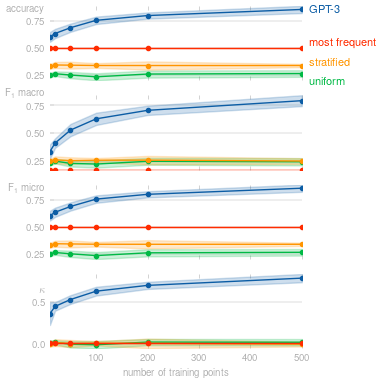

In [35]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4,1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex=True)

    # accuracy
    ax[0].plot(
        extracted_res_grouped.index, 
        extracted_res_grouped['accuracy']['mean'],
        label='GPT-3',
       marker='o',
    )
    ax[0].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped['accuracy']['mean'] - extracted_res_grouped['accuracy']['sem'],
        extracted_res_grouped['accuracy']['mean'] + extracted_res_grouped['accuracy']['sem'],
        alpha=.2,
        #label='GPT-3',
        color='C0',
    )

    # add the dummy models 
    for i, estimator in enumerate(estimators):
        ax[0].plot(
            dummy_grouped.loc[estimator, :]['accuracy']['mean'].index,
            dummy_grouped.loc[estimator, :]['accuracy']['mean'],
            label=estimator.replace('_', ' '),
            marker='o',
            color=f'C{i+1}'
        )
        ax[0].fill_between(
            dummy_grouped.loc[estimator, :]['accuracy']['mean'].index,
            dummy_grouped.loc[estimator, :]['accuracy']['mean'] - dummy_grouped.loc[estimator, :]['accuracy']['sem'],
            dummy_grouped.loc[estimator, :]['accuracy']['mean'] + dummy_grouped.loc[estimator, :]['accuracy']['sem'],
            alpha=.2,
            color=f'C{i+1}',
        )

    # f1 macro 
    ax[1].plot(
        extracted_res_grouped.index, 
        extracted_res_grouped['f1_macro']['mean'],
        label='GPT-3',
        marker='o',
    )
    ax[1].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped['f1_macro']['mean'] - extracted_res_grouped['f1_macro']['sem'],
        extracted_res_grouped['f1_macro']['mean'] + extracted_res_grouped['f1_macro']['sem'],
        alpha=.2,
        color='C0',
    )

    # add the dummy models 
    for i, estimator in enumerate(estimators):
        ax[1].plot(
            dummy_grouped.loc[estimator, :]['f1_macro']['mean'].index,
            dummy_grouped.loc[estimator, :]['f1_macro']['mean'],
            label=estimator.replace('_', ' '),
            marker='o',
            color=f'C{i+1}'
        )
        ax[1].fill_between(
            dummy_grouped.loc[estimator, :]['f1_macro']['mean'].index,
            dummy_grouped.loc[estimator, :]['f1_macro']['mean'] - dummy_grouped.loc[estimator, :]['f1_macro']['sem'],
            dummy_grouped.loc[estimator, :]['f1_macro']['mean'] + dummy_grouped.loc[estimator, :]['f1_macro']['sem'],
            alpha=.2,
            color=f'C{i+1}',
        )

    # f1 micro 

    ax[2].plot(
        extracted_res_grouped.index, 
        extracted_res_grouped['f1_micro']['mean'],
        label='GPT-3',
        marker='o',
    )
    ax[2].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped['f1_micro']['mean'] - extracted_res_grouped['f1_micro']['sem'],
        extracted_res_grouped['f1_micro']['mean'] + extracted_res_grouped['f1_micro']['sem'],
        alpha=.2,
        color='C0',
    )

    # add the dummy models 
    for i, estimator in enumerate(estimators):
        ax[2].plot(
            dummy_grouped.loc[estimator, :]['f1_micro']['mean'].index,
            dummy_grouped.loc[estimator, :]['f1_micro']['mean'],
            label=estimator.replace('_', ' '),
            marker='o',
            color=f'C{i+1}'
        )
        ax[2].fill_between(
            dummy_grouped.loc[estimator, :]['f1_micro']['mean'].index,
            dummy_grouped.loc[estimator, :]['f1_micro']['mean'] - dummy_grouped.loc[estimator, :]['f1_micro']['sem'],
            dummy_grouped.loc[estimator, :]['f1_micro']['mean'] + dummy_grouped.loc[estimator, :]['f1_micro']['sem'],
            alpha=.2,
            color=f'C{i+1}',
        )


    # kappa
    ax[3].plot(
        extracted_res_grouped.index, 
        extracted_res_grouped['kappa']['mean'],
        label='GPT-3',
        marker='o',
    )
    ax[3].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped['kappa']['mean'] - extracted_res_grouped['kappa']['sem'],
        extracted_res_grouped['kappa']['mean'] + extracted_res_grouped['kappa']['sem'],
        alpha=.2,
        color='C0',
    )

    # add the dummy models 
    for i, estimator in enumerate(estimators):
        ax[3].plot(
            dummy_grouped.loc[estimator, :]['kappa']['mean'].index,
            dummy_grouped.loc[estimator, :]['kappa']['mean'],
            label=estimator.replace('_', ' '),
            marker='o',
            color=f'C{i+1}'
        )
        ax[3].fill_between(
            dummy_grouped.loc[estimator, :]['kappa']['mean'].index,
            dummy_grouped.loc[estimator, :]['kappa']['mean'] - dummy_grouped.loc[estimator, :]['kappa']['sem'],
            dummy_grouped.loc[estimator, :]['kappa']['mean'] + dummy_grouped.loc[estimator, :]['kappa']['sem'],
            alpha=.2,
            color=f'C{i+1}',
        )
    
    

    matplotx.ylabel_top('accuracy', ax=ax[0])
    matplotx.ylabel_top(r'F$_{1}$ macro', ax=ax[1])
    matplotx.ylabel_top(r'F$_{1}$ micro', ax=ax[2])
    matplotx.ylabel_top(r'$\kappa$', ax=ax[3])
    ax[-1].set_xlabel('number of training points', labelpad=4)
    matplotx.line_labels(ax=ax[0], fontsize=8)

    fig.savefig('hea_phase_classifier.pdf', bbox_inches='tight')

In [15]:
dummy_grouped

accuracy            f1_macro           f1_micro  \
                             mean       std      mean       std     mean   
estimator     train_size                                                   
most_frequent 10           0.5000  0.000000  0.166667  0.000000   0.5000   
              20           0.5000  0.000000  0.166667  0.000000   0.5000   
              50           0.5000  0.000000  0.166667  0.000000   0.5000   
              100          0.5000  0.000000  0.166667  0.000000   0.5000   
              200          0.5000  0.000000  0.166667  0.000000   0.5000   
              500          0.5000  0.000000  0.166667  0.000000   0.5000   
stratified    10           0.3420  0.022959  0.252054  0.025392   0.3420   
              20           0.3284  0.020609  0.238542  0.025985   0.3284   
              50           0.3388  0.030814  0.255026  0.040926   0.3388   
              100          0.3460  0.014142  0.259346  0.009087   0.3460   
              200          0.3412  0.027001  0.256385  0.028128   0.3412   
              500          0.3444  0.021783  0.253038  0.029667   0.3444   
uniform       10           0.2448  0.021811  0.225257  0.017930   0.2448   
              20           0.2536  0.033530  0.229699  0.032511   0.2536   
              50           0.2564  0.032575  0.238154  0.033715   0.2564   
              100          0.2628  0.018091  0.242178  0.016209   0.2628   
              200          0.2448  0.034399  0.226577  0.027197   0.2448   
              500          0.2476  0.029361  0.226819  0.030562   0.2476   

                                       kappa            
                               std      mean       std  
estimator     train_size                                
most_frequent 10          0.000000  0.000000  0.000000  
              20          0.000000  0.000000  0.000000  
              50          0.000000  0.000000  0.000000  
              100         0.000000  0.000000  0.000000  
              200         0.000000  0.000000  0.000000  
              500         0.000000  0.000000  0.000000  
stratified    10          0.022959  0.006102  0.034241  
              20          0.020609 -0.010100  0.033000  
              50          0.030814  0.004586  0.049633  
              100         0.014142  0.016582  0.017381  
              200         0.027001  0.011293  0.039166  
              500         0.021783  0.004233  0.028138  
uniform       10          0.021811 -0.005396  0.027080  
              20          0.033530  0.001207  0.033831  
              50          0.032575  0.008664  0.040562  
              100         0.018091  0.018441  0.019017  
              200         0.034399 -0.006635  0.040724  
              500         0.029361 -0.006582  0.044398

In [16]:
dummy_grouped.loc['most_frequent']

accuracy       f1_macro      f1_micro      kappa     
               mean  std      mean  std     mean  std  mean  std
train_size                                                      
10              0.5  0.0  0.166667  0.0      0.5  0.0   0.0  0.0
20              0.5  0.0  0.166667  0.0      0.5  0.0   0.0  0.0
50              0.5  0.0  0.166667  0.0      0.5  0.0   0.0  0.0
100             0.5  0.0  0.166667  0.0      0.5  0.0   0.0  0.0
200             0.5  0.0  0.166667  0.0      0.5  0.0   0.0  0.0
500             0.5  0.0  0.166667  0.0      0.5  0.0   0.0  0.0